# EDA

You will need to download the data provided by SteadySun from the GCP bucket.
```bash
gsutil -m cp -r "gs://steadycast/Images/MSG/Chambéry/2022" .
```

this will download the 2022 folder where you have subfolders for months of May and June.

## Loading data

In [1]:
import random
from pathlib import Path

In [2]:
def ls(path): return list(path.iterdir())

In [3]:
data_path = Path("2022")

only one file here!

In [4]:
files = ls(data_path/"06/05")
one_file = random.choice(files)

In [5]:
files.sort()

The data is in xarray format `NetCDF4`

In [6]:
import xarray as xr
import matplotlib.pyplot as plt

In [7]:
from utils import *

In [8]:
data = xr.open_dataset(one_file)

In [9]:
data

<xarray.Dataset>
Dimensions:    (latitude: 446, longitude: 780)
Coordinates:
  * longitude  (longitude) float64 3.004 3.013 3.022 3.031 ... 9.978 9.986 9.995
  * latitude   (latitude) float64 48.0 47.99 47.98 47.97 ... 44.02 44.01 44.0
Data variables:
    HRV        (latitude, longitude) float32 ...
    VIS        (latitude, longitude) float32 ...
    B03        (latitude, longitude) float32 ...
    B04        (latitude, longitude) float32 ...
    B07        (latitude, longitude) float32 ...
    B09        (latitude, longitude) float32 ...
    B11        (latitude, longitude) float32 ...
    IR108      (latitude, longitude) float32 ...
    B15        (latitude, longitude) float32 ...
    B16        (latitude, longitude) float32 ...
    B14        (latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    time:         2022-06-05 22:45:00
    description:  Satellite image for zone Chambéry

In [10]:
visible = data.VIS.values
visible.shape

(446, 780)

<AxesSubplot: >

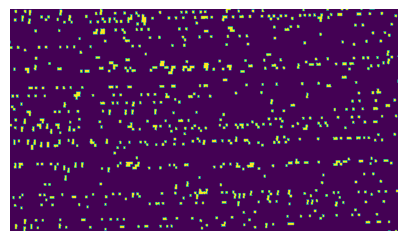

In [11]:
show_image(visible)

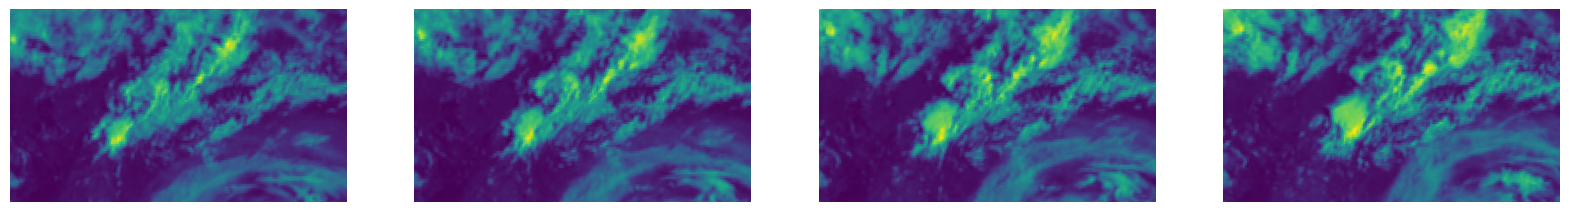

In [12]:
show_images([xr.open_dataset(f).VIS.values for f in files[30:34]], figsize=(20,20))

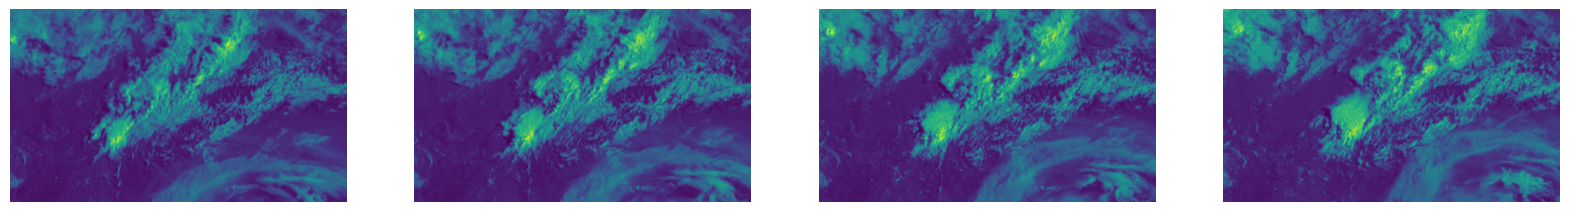

In [13]:
show_images([xr.open_dataset(f).HRV.values for f in files[30:34]], figsize=(20,20))

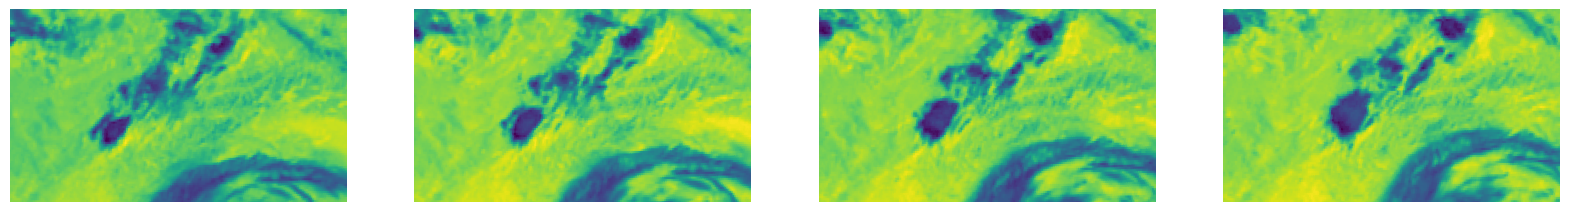

In [14]:
show_images([xr.open_dataset(f).B07.values for f in files[30:34]], figsize=(20,20))

In [15]:
import wandb

In [16]:
for x in data.data_vars:
    print(data[x].values.shape)

(446, 780)
(446, 780)
(446, 780)
(446, 780)
(446, 780)
(446, 780)
(446, 780)
(446, 780)
(446, 780)
(446, 780)
(446, 780)


## log to W&B

In [17]:
data.attrs

{'Conventions': 'CF-1.6',
 'time': '2022-06-05 22:45:00',
 'description': 'Satellite image for zone Chambéry'}

In [18]:
import wandb
import cv2
from fastprogress import progress_bar

In [19]:
columns = list(data.keys())

columns = ["date"] + columns
columns

['date',
 'HRV',
 'VIS',
 'B03',
 'B04',
 'B07',
 'B09',
 'B11',
 'IR108',
 'B15',
 'B16',
 'B14']

In [46]:
n = 10
resize_factor = 1

In [64]:
# table = wandb.Table(columns = columns)

In [65]:
orig_size = data.HRV.values.shape
new_size = (orig_size[1]//resize_factor, orig_size[0]//resize_factor)

In [71]:
sequences = {}
for f in progress_bar(files[40:(n+40)]):
    data = xr.open_dataset(f)
    images = [cv2.resize(data[x].values, new_size) for x in data.data_vars]
    for var, img in zip(data.data_vars, images):
        if var in sequences:
            sequences[var].append(img)
        else:
            sequences[var] = [img]
    # row = [data.attrs["time"]] + [wandb.Image(img) for img in images]
    # table.add_data(*row)

In [72]:
for var in data.data_vars:
    vid = np.stack(sequences[var])[:, None, ...]
    vid = (vid/vid.max()) * 255
    sequences[var] = wandb.Video(vid)

In [79]:
table = wandb.Table(columns = columns)
table.add_data(*[data.attrs["time"]] + list(sequences.values()))

In [80]:
with wandb.init(project="xarray"):
    # for img in visible:
    #     wandb.log({"visible":wandb.Image(img)})
    wandb.log({f"vid 06/05-{n}": table})
    

In [50]:
video = np.stack(visible)
video = video[:,None,...]
video.shape

(10, 1, 446, 780)

In [51]:
vid = wandb.Video((video/video.max())*255)

In [52]:
with wandb.init(project="xarray"):
    wandb.log({"visible_vid":vid})